# Import Library

In [ ]:
import torch, torchvision, time
import numpy as np
from numpy.random import seed
from numpy import transpose
from matplotlib import pyplot as plt
from warnings import filterwarnings as fw; fw("ignore")

#Menampilkan Gambar dari Tensor (imshow)

In [ ]:
def imshow(img : torch.Tensor, *args, **kwargs) -> None:
  img = img / 2 + 0.5 #unormalize
  npimg = img.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(transpose(npimg, (1,2,0)))
  plt.show()

# Seed

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Inisialisasi seed untuk CUDA (jika digunakan)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Hyper Parameter

In [ ]:
EPOCH = 300
BATCH_SIZE = 16
LEARNING_RATE = 1e-3 #1e-3

# Data Transformation

In [ ]:
fixed_size = (256, 256)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(fixed_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.GaussianBlur(kernel_size=3),
    torchvision.transforms.Normalize(*stats, inplace=True)
])

# Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Splitting

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path ke direktori dataset utama
dataset_path = '/content/drive/MyDrive/dataset_modifikasi/'

# Path untuk direktori output train, val, dan test
output_path = '/content/drive/MyDrive/DatasetmodifikasiNew_Split'
os.makedirs(output_path, exist_ok=True)

# Mendapatkan daftar semua kelas (folder) di dataset
classes = os.listdir(dataset_path)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    # Membagi dataset untuk setiap kelas menjadi train, val, dan test
    train_path, test_val_path = train_test_split(os.listdir(class_path), test_size=0.2, random_state=0)
    val_path, test_path = train_test_split(test_val_path, test_size=0.5, random_state=0)

    # Membuat direktori output untuk setiap set (train, val, test)
    train_output = os.path.join(output_path, 'train', class_name)
    val_output = os.path.join(output_path, 'val', class_name)
    test_output = os.path.join(output_path, 'test', class_name)

    os.makedirs(train_output, exist_ok=True)
    os.makedirs(val_output, exist_ok=True)
    os.makedirs(test_output, exist_ok=True)

    # Memindahkan file ke direktori output
    for file_name in train_path:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(train_output, file_name))

    for file_name in val_path:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(val_output, file_name))

    for file_name in test_path:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(test_output, file_name))

#  DataLoader Setup

In [ ]:
  # Training and validation sets

  train_dataset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/DatasetmodifikasiNew_Split/train", transform=data_transform)
  total_length = len(train_dataset)

  # Tentukan rasio untuk pembagian
  train_ratio = 0.8  # contoh: 80% untuk pelatihan
  valid_ratio = 0.2  # contoh: 20% untuk validasi

  # Hitung panjang untuk pelatihan dan validasi
  train_length = int(train_ratio * total_length)
  valid_length = total_length - train_length

  # Gunakan panjang yang dihitung untuk pembagian
  train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_length, valid_length])

  # Test set
  test_dataset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/DatasetmodifikasiNew_Split/test", transform=data_transform)

  # DATALOAD ---> assign raw datasets into mini-batches
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total TRAIN dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch".
      format(len(train_dataset), len(train_loader), BATCH_SIZE))

Total TRAIN dataset: 1579.
For mini-batch settings, there will be 99 batches, with 16 data for each batch


In [ ]:
print("Total VALIDATION dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch".
      format(len(test_dataset), len(test_loader), BATCH_SIZE))

Total VALIDATION dataset: 390.
For mini-batch settings, there will be 25 batches, with 16 data for each batch


In [ ]:
print("Total TEST dataset: {}.\nFor mini-batch settings, there will be {} batches, with {} data for each batch".
      format(len(test_dataset), len(test_loader), BATCH_SIZE))

Total TEST dataset: 390.
For mini-batch settings, there will be 25 batches, with 16 data for each batch


# Dataset Label

In [ ]:
cabe_label = ['Healthy', 'Leaf Curl', 'Leaf Spot', 'Powdery Mildew', 'White Fly', 'Yellowish']

# Displaying Training Set Samples

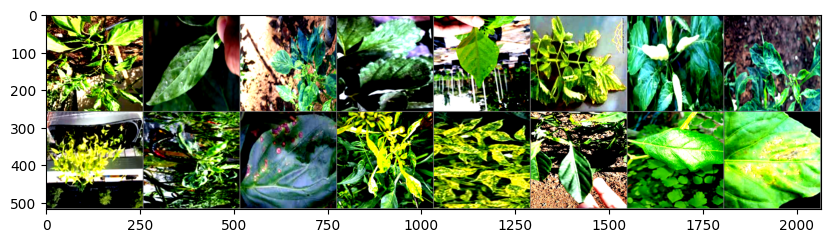

LABELS (every 8 labels, going down):
White Fly, Powdery Mildew, Leaf Curl, Powdery Mildew, Healthy, Yellowish, Healthy, Leaf Curl
Yellowish, Leaf Curl, Leaf Spot, Yellowish, Yellowish, Healthy, Healthy, Leaf Spot


In [ ]:
from torchvision import transforms

dataiter = iter(train_loader)
images, labels = next(dataiter)
valid_labels = [cabe_label[i] for i in labels if i < len(cabe_label)]

imshow(img=torchvision.utils.make_grid(images))
print("LABELS (every 8 labels, going down):")
for i in range(0, len(valid_labels), 8):
    print(", ".join(valid_labels[i:i+8]))

# ResNet-18 Architecture Implementation

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, n_class=6):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, n_class)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class BaseResNet(nn.Module):
    def __init__(self, n_class=6):
        super(BaseResNet, self).__init__()
        self.resnet = ResNet(n_class=n_class)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

# Use BaseResNet as the model
model = BaseResNet(n_class=6)

# Device Selection: GPU or CPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Model Initialization

In [ ]:
model = BaseResNet(n_class=6).to(device)
model

BaseResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e

# Loss Function Definition: CrossEntropyLoss

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

# Setting SGD Optimizer

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Training Loop with Validation and Checkpoint Saving

In [ ]:
TRAIN_LOSS, TRAIN_ACC = [], []
train_batches = len(train_loader)

VAL_LOSS, VAL_ACC = [], []
val_batches = len(valid_loader)

best_val_acc = 0.0
best_epoch = 0
checkpoint_path = "/path/to/save/checkpoint.pth"

for e in range(EPOCH):
    train_losses = 0
    train_accuracies = 0

    # Training
    model.train()
    for i, data in enumerate(train_loader):
        # ... (Bagian pelatihan)
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()

        # Measure accuracy
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

    TRAIN_ACC.append(train_accuracies / train_batches)
    TRAIN_LOSS.append(train_losses / train_batches)

    # Validation
    val_losses = 0
    val_accuracies = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            # ... (Bagian evaluasi)
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            val_losses += loss_function(outputs, y).item()

            # Measure accuracy
            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

    VAL_ACC.append(val_accuracies / val_batches)
    VAL_LOSS.append(val_losses / val_batches)

    # Save checkpoint if the current model has the best validation accuracy
    if VAL_ACC[-1] > best_val_acc:
        best_val_acc = VAL_ACC[-1]
        best_epoch = e
        # Pastikan direktori ada sebelum menyimpan checkpoint
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': TRAIN_LOSS[-1],
            'train_acc': TRAIN_ACC[-1],
            'val_loss': VAL_LOSS[-1],
            'val_acc': VAL_ACC[-1],
        }, checkpoint_path)

    # Print training and validation metrics
    print("EPOCH {}/{}".format(e + 1, EPOCH))
    print("Training Loss: {:.3f}, accuracy {:.3f}%".format(TRAIN_LOSS[-1], TRAIN_ACC[-1] * 100))
    print("Validation Loss: {:.3f}, accuracy {:.3f}%".format(VAL_LOSS[-1], VAL_ACC[-1] * 100))


EPOCH 1/300
Training Loss: 1.583, accuracy 34.487%
Validation Loss: 1.230, accuracy 51.773%
EPOCH 2/300
Training Loss: 1.367, accuracy 44.622%
Validation Loss: 1.126, accuracy 56.432%
EPOCH 3/300
Training Loss: 1.269, accuracy 49.541%
Validation Loss: 1.020, accuracy 63.295%
EPOCH 4/300
Training Loss: 1.244, accuracy 51.090%
Validation Loss: 1.065, accuracy 60.045%
EPOCH 5/300
Training Loss: 1.181, accuracy 52.858%
Validation Loss: 0.986, accuracy 62.659%
EPOCH 6/300
Training Loss: 1.148, accuracy 54.494%
Validation Loss: 1.015, accuracy 60.182%
EPOCH 7/300
Training Loss: 1.155, accuracy 52.864%
Validation Loss: 1.000, accuracy 61.795%
EPOCH 8/300
Training Loss: 1.081, accuracy 57.059%
Validation Loss: 0.959, accuracy 66.795%
EPOCH 9/300
Training Loss: 1.061, accuracy 56.480%
Validation Loss: 0.916, accuracy 65.295%
EPOCH 10/300
Training Loss: 1.042, accuracy 59.797%
Validation Loss: 1.120, accuracy 59.773%
EPOCH 11/300
Training Loss: 1.019, accuracy 59.831%
Validation Loss: 0.910, acc

# Model Performance Evaluation on Validation Set

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Fungsi untuk menghitung dan menampilkan metrics
def evaluate_model(model, data_loader, device, class_labels):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Menghitung dan menampilkan metrics
    report = classification_report(all_labels, all_predictions, target_names=class_labels)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print("Classification Report:\n", report)
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 Score: {:.3f}".format(f1))

# Evaluasi model pada set validasi
evaluate_model(model, valid_loader, device, cabe_label)

Classification Report:
                 precision    recall  f1-score   support

       Healthy       1.00      0.89      0.94        62
     Leaf Curl       0.92      0.98      0.95        57
     Leaf Spot       0.97      0.97      0.97        65
Powdery Mildew       0.94      0.97      0.96        68
     White Fly       0.91      0.94      0.93        67
     Yellowish       0.99      0.97      0.98        76

      accuracy                           0.95       395
     macro avg       0.95      0.95      0.95       395
  weighted avg       0.96      0.95      0.95       395

Accuracy: 0.954
Precision: 0.956
Recall: 0.954
F1 Score: 0.954


# Model Performance Evaluation on Training Set

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Fungsi untuk menghitung dan menampilkan metrics
def evaluate_model(model, data_loader, device, class_labels):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Menghitung dan menampilkan metrics
    report = classification_report(all_labels, all_predictions, target_names=class_labels)
    accuracy = accuracy_score(all_labels, all_predictions)

    print("Classification Report:\n", report)
    print("Accuracy: {:.3f}".format(accuracy))

# Evaluasi model pada set validasi
evaluate_model(model, train_loader, device, cabe_label)

Classification Report:
                 precision    recall  f1-score   support

       Healthy       0.99      1.00      1.00       267
     Leaf Curl       1.00      0.99      0.99       272
     Leaf Spot       1.00      1.00      1.00       264
Powdery Mildew       1.00      1.00      1.00       261
     White Fly       1.00      1.00      1.00       262
     Yellowish       1.00      1.00      1.00       253

      accuracy                           1.00      1579
     macro avg       1.00      1.00      1.00      1579
  weighted avg       1.00      1.00      1.00      1579

Accuracy: 0.998


# Model Evaluation on Combined Training and Validation Sets

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ...

def evaluate_model(model, data_loader, device, class_labels):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Menghitung dan menampilkan metrics
    report = classification_report(all_labels, all_predictions, target_names=class_labels)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Menghitung precision, recall, dan f1-score untuk setiap kelas
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    # Menampilkan metrics untuk setiap kelas
    print("Classification Report:\n", report)

    # Menampilkan akurasi
    print("Accuracy: {:.3f}".format(accuracy))

    # Menampilkan precision, recall, dan f1-score untuk semua kelas
    print("Precision (weighted): {:.3f}".format(precision))
    print("Recall (weighted): {:.3f}".format(recall))
    print("F1-Score (weighted): {:.3f}".format(f1))

# Evaluasi model pada gabungan set pelatihan dan validasi
evaluate_model(model, combined_loader, device, cabe_label)

Classification Report:
                 precision    recall  f1-score   support

       Healthy       1.00      0.98      0.99       329
     Leaf Curl       0.98      1.00      0.99       329
     Leaf Spot       1.00      0.99      1.00       329
Powdery Mildew       0.99      0.99      0.99       329
     White Fly       0.98      0.99      0.99       329
     Yellowish       1.00      1.00      1.00       329

      accuracy                           0.99      1974
     macro avg       0.99      0.99      0.99      1974
  weighted avg       0.99      0.99      0.99      1974

Accuracy: 0.992
Precision (weighted): 0.992
Recall (weighted): 0.992
F1-Score (weighted): 0.992


In [ ]:
from PIL import Image

# Fungsi untuk memuat dan memproses gambar uji
def load_and_process_image(image_path):
    # Muat gambar menggunakan PIL
    img = Image.open(image_path)

    # Transformasi gambar
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])

    # Terapkan transformasi pada gambar
    img = transform(img)

    # Tambahkan dimensi batch (batch dimension)
    img = img.unsqueeze(0)

    return img

# Confussion Matrix

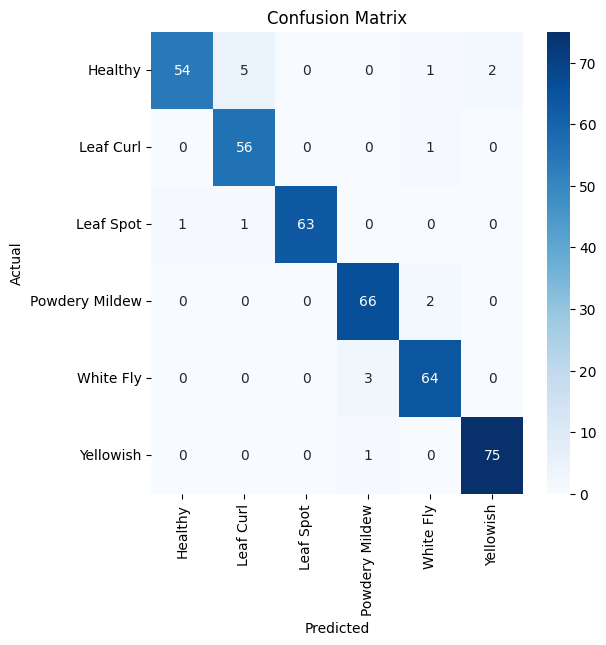

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(model, data_loader, device, class_labels):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Menghitung confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(len(class_labels), len(class_labels)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Tampilkan plot confusion matrix
plot_confusion_matrix(model, valid_loader, device, cabe_label)

# Model Performance Plot

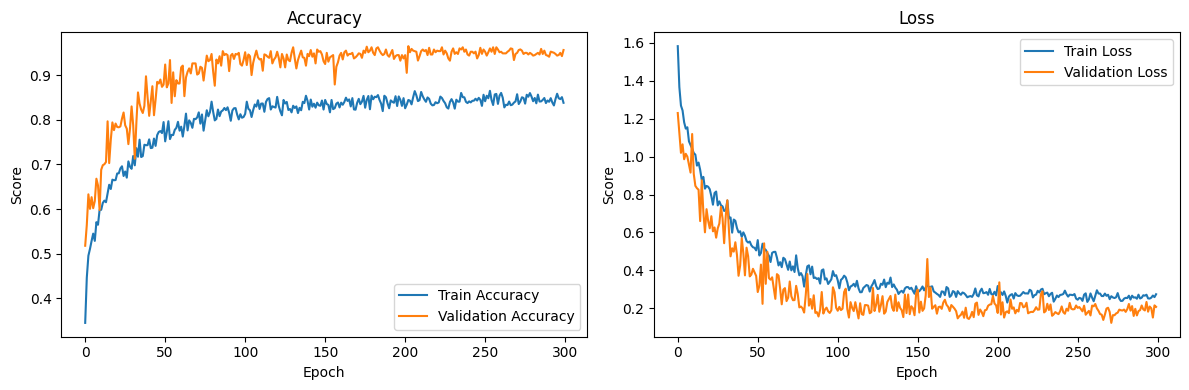

In [ ]:
import matplotlib.pyplot as plt

# Plot train accuracy and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(TRAIN_ACC, label="Train Accuracy")
plt.plot(VAL_ACC, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend(loc="best")

# Plot train loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(TRAIN_LOSS, label="Train Loss")
plt.plot(VAL_LOSS, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


# Image Inference and Visualization Function

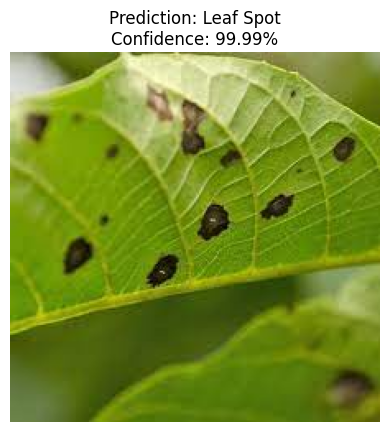

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar dengan label dan persentase prediksi
def display_image_with_prediction(image_path, predicted_class_label, confidence):
    # Baca dan tampilkan gambar
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')

    # Tampilkan label prediksi dan persentase
    plt.title(f'Prediction: {predicted_class_label}\nConfidence: {confidence:.2f}%')

    # Tampilkan gambar
    plt.show()

# Fungsi untuk memuat dan memproses gambar uji
def load_and_process_image(image_path):
    # Muat gambar menggunakan PIL
    img = Image.open(image_path)

    # Transformasi gambar (sesuaikan dengan praproses yang diperlukan oleh model)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Sesuaikan ukuran gambar dengan kebutuhan model
        transforms.ToTensor(),
        torchvision.transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])

    # Terapkan transformasi pada gambar
    img = transform(img)

    # Tambahkan dimensi batch (batch dimension)
    img = img.unsqueeze(0)

    return img

# Fungsi untuk mendapatkan label kelas
def get_class_label(class_index, class_labels):
    return class_labels[class_index]

# Tentukan path gambar uji
test_image_path = "/content/drive/MyDrive/dataset_test/leaf spot 2.jpeg"

# Muat dan proses gambar
test_image = load_and_process_image(test_image_path)

# Pindahkan model ke mode evaluasi
model.eval()

# Lakukan inferensi
with torch.no_grad():
    output = model(test_image.to(device))

# Dapatkan indeks kelas dengan probabilitas tertinggi
predicted_class_index = torch.argmax(output).item()

# Dapatkan label kelas dan probabilitas prediksi
predicted_class_label = get_class_label(predicted_class_index, cabe_label)
confidence = torch.nn.functional.softmax(output, dim=1)[0][predicted_class_index].item() * 100

# Tampilkan gambar bersama dengan label dan persentase prediksi
display_image_with_prediction(test_image_path, predicted_class_label, confidence)